In [136]:
import torch
from torch import nn 
import numpy as np
import matplotlib.pyplot as plt

# From data to model deployment: the PyTorch workflow

In the first notebook, `introduction-to-tensors`, we discussed the concept of tensors and explored the main methods and functions used to manipulate them. We can now move on to how tensors—and the PyTorch library more broadly—can be used to define, train, and evaluate machine learning models. We'll start with the basics, using the simplest machine learning model: linear regression. The goal here is not to explain linear regression itself in detail, but rather to demonstrate how a typical machine learning **workflow** can be implemented using PyTorch—from the initial train/test split to model deployment.

In [137]:
# define parameter
m = .5
b = .3

In [138]:
# Synthetically creating data
a = 0
b = 1 
step = 0.01

X = torch.arange(a, b, step).unsqueeze(dim=1)

In [139]:
X.shape

torch.Size([100, 1])

We defined the `X` tensor, storing the X values of our linear function. As for the y values:

In [140]:
# The linear function
y = m * X + b

`X` and `y` represent the initial data: `X` are the feature values, while `y` is the target variable. Our goal is to learn a regression model, i.e learn the parameters `m` and `b` which define the relationship between features and labels (y). 

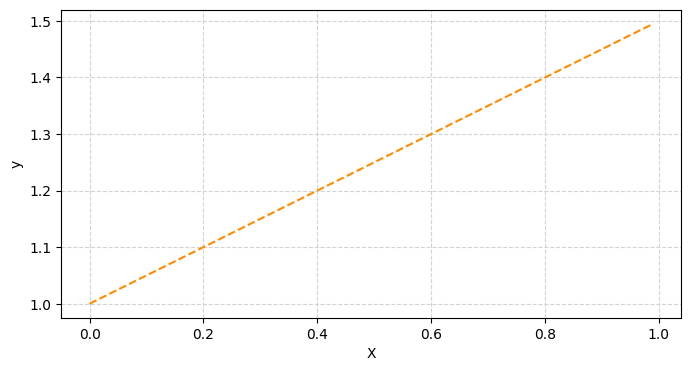

In [141]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(X.numpy(), y.numpy(), linestyle="--", color="darkorange")
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.grid(True, linestyle="--", c="lightgray")

## Data Preparation

Before building a model, we need to split our data into three datasets:

- **Training set**: This dataset is used to train the model, i.e., to learn the model parameters. Typically, 60–80% of the original dataset is used for training.
- **Validation set**: This dataset is used to tune the model, i.e., to adjust the hyperparameters that the model depends on in order to achieve the best performance according to a chosen metric (e.g., accuracy). The validation set is not always used, but when it is, it usually represents around 10–20% of the original dataset.
- **Test set**: This dataset is used to evaluate the model after the training phase. It typically accounts for 10–20% of the original dataset.

In [142]:
# A function to split the dataset 
def line_train_test_split(X, y, p: float = 0.80):

    # Define the train split
    train_split = int(p * len(X))

    X_train, y_train = X[:train_split], y[:train_split]
    X_test, y_test = X[train_split:], y[train_split:]

    return X_train, y_train, X_test, y_test

In [143]:
X_train, y_train, X_test, y_test = line_train_test_split(X, y)

## A Linear Regression model in PyTorch

Let’s now build a linear regression model to learn the relationship between `X` and `y`. While we could use the linear regression implementation from scikit-learn, the goal here is to demonstrate how a similar model can be built using PyTorch. We'll first write out the complete code and then go through each part in detail.

In [144]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad = True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad = True)

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Linear regression formula
        return self.weights * x + self.bias

First of all, we defined a class called `LinearRegressionModel`, which inherits from `nn.Module`. In PyTorch, almost everything is based on `nn.Module`. The nn module (short for neural networks) contains all the building blocks needed for deep learning models. `Module` is the base class for constructing any neural network. When creating a custom model, we define a class that extends `Module`. **<span style="color: red">This base class requires the implementation of a `forward` method, which specifies the computation to be performed on the input data</span>**.

The `nn.Parameter` class is used to store tensors that should be treated as learnable parameters within a model. If `requires_grad` is set to True, PyTorch will automatically compute gradients for these parameters during backpropagation—one of the major advantages of using PyTorch tensors.

In [145]:
# Check a PyTorch model
torch.manual_seed(42)

In [146]:
# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
lr_model = LinearRegressionModel()

In [147]:
# Check the nn.Parameter(s) within the nn.Module subclass we created
list(lr_model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get the state of the model, i.e. what the model "contains", using:

In [148]:
lr_model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

`weights` and `bias` have been initialized as random tensors. 

### Making a prediction

As mentioned earlier, when we pass data to the model, it is processed through the `forward` method. To obtain the predicted values (i.e., perform inference), we need to set the model to inference mode. This is done using `torch.inference_mode()`, which is a Python *context manager*:

In [149]:
with torch.inference_mode():
    y_preds = lr_model(X_train)

In [150]:
y_preds[0]

tensor([0.1288])

Naturally, the values produced at this stage will be quite poor and far from the true target values, since we haven’t optimized the model parameters yet—we’re simply making predictions based on randomly initialized parameters. In fact:

In [151]:
# The predicted value is simply the one obtained by passing the values in the forward formula 
X_train[0]*lr_model.weights + lr_model.bias

tensor([0.1288], grad_fn=<AddBackward0>)

Let's plot the test and predicted values for comparison:

In [152]:
with torch.inference_mode():
    y_predictions = lr_model(X_test)

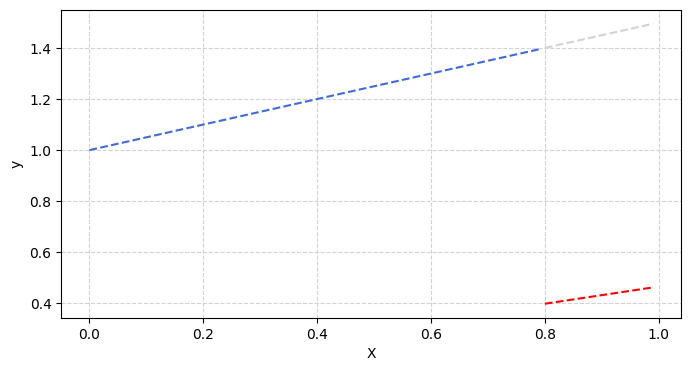

In [153]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(X_train.numpy(), y_train.numpy(), linestyle="--", color="royalblue", label="Training")
ax.plot(X_test.numpy(), y_test.numpy(), linestyle="--", color="lightgrey", label="Test")
ax.plot(X_test.numpy(), y_predictions.numpy(), linestyle="--", color="red", label="Prediction")
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.grid(True, linestyle="--", c="lightgray")

Of course, as expected, our predictions are very bad, because so far we have just initialized at random the learning parameters. We need to update these parameters so that they can better represent the data. In other words, we need to *train* our model.

### Train the model

To train a model in PyTorch, we need to introduce two additional components:

- **Loss function**: a function that measures how far our model’s predictions are from the true values, i.e., how much the predicted outputs differ from the targets.  
- **Optimizer**: the algorithm that updates the model’s internal parameters in order to minimize the loss.

PyTorch provides built-in implementations of both loss functions and optimizers. For loss functions, the most commonly used are **Mean Absolute Error (MAE)** for regression and **Binary Cross-Entropy (BCE)** for classification problems. Since we are training a linear regression model, we will use **MAE**, which is defined as:

$$
MAE = \frac{1}{N} \sum_{i=1}^N |y_p^{(i)} - y_t^{(i)}|
$$

where $y_p$ are the predicted values and $y_t$ are the true values.  

As for optimizers, two of the most widely used are **Stochastic Gradient Descent (SGD)** and the **Adam optimizer**. At the end of this notebook, we will cover the mathematical details of these optimization methods. For now, let’s see how to apply them in PyTorch to train our linear regression model.


In [154]:
# L1Loss is MAE in PyTorch
lr_loss = nn.L1Loss()

In [155]:
# Create the optimizer
lr_optimizer = torch.optim.SGD(
    params = lr_model.parameters(),
    lr=0.01
)

We are using the *Stochastic Gradient Descent* optimizer, which is defined in PyTorch with `torch.optim.SGD()`. This built-in function takes two main arguments:

1. `params`: the model parameters to optimize;  
2. `lr`: the **learning rate**, which controls the step size of each update. Higher values correspond to larger updates, while lower values correspond to smaller updates.  

If the learning rate is too high, the optimizer may fail to converge; if it is too low, the training process can become very slow. The learning rate is a **hyperparameter**, meaning it must be chosen and set manually by the machine learning engineer.

Below, the full code to train and test the model. Let's run it and then discuss it step-by-step:

In [156]:
# Set the number of epochs: how many times the model will pass over the training data
epochs = 100

In [157]:
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

In [158]:
# TRAINING LOOP
torch.manual_seed(42)

for epoch in range(epochs):
    ### TRAINING

    # This command put the model in training mode
    lr_model.train()

    # 1. Pass the training data through the forward() method of the model
    y_pred = lr_model(X_train)

    # 2. Calculate the loss between predicted and true values
    loss = lr_loss(y_pred, y_train)

    # 3. Zero grad of the optimizer --> we zero the gradients since they accumalate at each epochs
    lr_optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Progress the optimizer
    lr_optimizer.step()

    ### TESTING
    # Put the model in evaluation mode
    lr_model.eval()

    # Make the inference
    with torch.inference_mode():
        # 1. Forward pass on test data
        test_pred = lr_model(X_test)

        # 2. Caculate loss on test data
        # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type
        test_loss = lr_loss(test_pred, y_test.type(torch.float)) 

        # Print out what's happening 
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().item())
            test_loss_values.append(test_loss.detach().item())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.9356979131698608 | MAE Test Loss: 1.0038174390792847 
Epoch: 10 | MAE Train Loss: 0.8200953602790833 | MAE Test Loss: 0.8684649467468262 
Epoch: 20 | MAE Train Loss: 0.7044928669929504 | MAE Test Loss: 0.7331124544143677 
Epoch: 30 | MAE Train Loss: 0.588890552520752 | MAE Test Loss: 0.597760021686554 
Epoch: 40 | MAE Train Loss: 0.47328799962997437 | MAE Test Loss: 0.4624076783657074 
Epoch: 50 | MAE Train Loss: 0.3576856553554535 | MAE Test Loss: 0.3270552456378937 
Epoch: 60 | MAE Train Loss: 0.24208326637744904 | MAE Test Loss: 0.19170284271240234 
Epoch: 70 | MAE Train Loss: 0.1264808475971222 | MAE Test Loss: 0.05635044723749161 
Epoch: 80 | MAE Train Loss: 0.03413804620504379 | MAE Test Loss: 0.05251990631222725 
Epoch: 90 | MAE Train Loss: 0.027357865124940872 | MAE Test Loss: 0.06144831329584122 


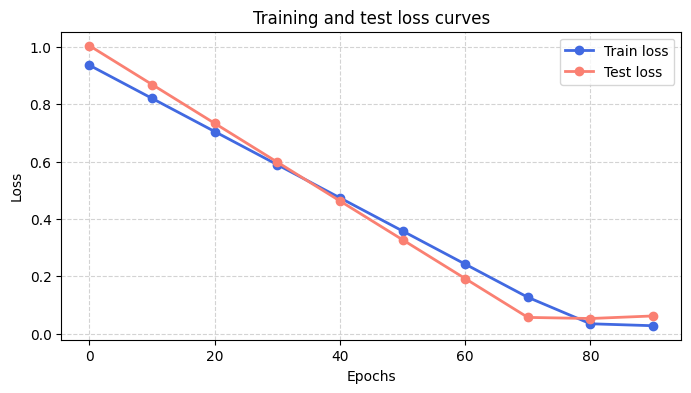

In [159]:
# Plot the loss curves
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(epoch_count, train_loss_values, label="Train loss", color="royalblue", linewidth=2, marker="o")
ax.plot(epoch_count, test_loss_values, label="Test loss", color="salmon", linewidth=2, marker="o")
ax.set_title("Training and test loss curves")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")

ax.grid(True, linestyle="--", color="lightgrey")
ax.legend()
plt.show()